### some feature selection

### Makin models from all the features

I make sure that columns are the right data types and fill nan values with the appropriate values. I also made season and reno columns. season is categorical and contains what season the sale happened in. reno is 1 for has been renovated and 0 for hasn't been renovated. I tried multiple models with different kinds of data transformations and the normal linear regression was the best.

### Feature Selection

I looked at many interactions bbetween variables that are shown in the interactions notebook. I picked the best ones and then dropped the individual features to prevent colinearity. I also made a barplot of the weights of each feature and took out the very lowest ones.

In [1]:
#Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Column Names and descriptions for Kings County Data Set
* **id** - unique identified for a house
* **dateDate** - house was sold
* **pricePrice** -  is prediction target
* **bedroomsNumber** -  of Bedrooms/House
* **bathroomsNumber** -  of bathrooms/bedrooms
* **sqft_livingsquare** -  footage of the home
* **sqft_lotsquare** -  footage of the lot
* **floorsTotal** -  floors (levels) in house
* **waterfront** - House which has a view to a waterfront
* **view** - Has been viewed
* **condition** - How good the condition is ( Overall )
* **grade** - overall grade given to the housing unit, based on King County grading system
* **sqft_above** - square footage of house apart from basement
* **sqft_basement** - square footage of the basement
* **yr_built** - Built Year
* **yr_renovated** - Year when house was renovated
* **zipcode** - zip
* **lat** - Latitude coordinate
* **long** - Longitude coordinate
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors


Here, I am reading in all of the data that we found from external sources and joining them all together.

In [2]:
#read in the cleaned df and set col index

df = pd.read_csv('cleaned_df',index_col=0)
df_med = pd.read_csv('mediandf.csv',index_col=0)
df_wf = pd.read_csv('Closest_WF',index_col=0)
df_wf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21577 entries, 0 to 21596
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Closest_WF  21577 non-null  float64
dtypes: float64(1)
memory usage: 337.1 KB


I dropped the id column and then make all of the engineered features here.

In [4]:
#drop id col
df.drop('id',axis=1,inplace=True)
df = df.join(df_med)
df = df.join(df_wf)
#waterfront time grade
df['sqrt_long_times_WF'] = np.sqrt(abs(df['long'] * df['Closest_WF']))
df['yr_built_times_grade'] = df['yr_built'] * df['grade']
df['water_times_grade'] = df['waterfront'] * df['grade']
df['sqrt_sqft_above'] = np.sqrt(abs(df['sqft_above']))
df['int_WFlivgrd'] = np.sqrt(abs(df['sqft_living_times_grade'])) * np.sqrt(abs(df['Closest_WF']))
# ('sqft_living_times_grade', 'Closest_WF', 0.798)

I decided to drop 200 more of the most expensive houses to get a more normal price distribution.

In [5]:
drop_rows = df['price'].sort_values(ascending=False)[:200]
df.drop(drop_rows.index,axis=0,inplace=True)

In [6]:
#import model packages
#fir the basic model
#for testing
from sklearn.model_selection import cross_val_score
#adding some more model testing
from sklearn.model_selection import KFold
#train test split
from sklearn.model_selection import train_test_split
#scoring
#feature elimination
from sklearn.feature_selection import RFE
#scoring
from sklearn.metrics import mean_squared_error
#trying some polynomial features



This is where I set which categorical and continuous features to use in the model.

In [7]:
#defining which values are categorical or not
#'bedrooms','floors','condition','zipcode','season','view'
categoricals = ['bedrooms','waterfront','view','condition','reno','median_by_zip']

continuous = ['price','sqft_lot','sqrt_sqft_above','sqft_basement','lat','long',
              'sqft_living15','sqft_lot15',
              'bathrooms_sq','int_WFlivgrd']

df_cont = df[continuous]


In [8]:
#compare different scalers
#im going to make a function to take the output of scalers and git back the score
#then do it for multiple scalers

Now, one hot encode the categorical features and combine them with the continuous ones.

In [9]:
#one hot encode the categoricals
df_ohe = pd.get_dummies(df[categoricals])
#combine the data into one frame
preprocessed = pd.concat([df_cont, df_ohe],axis=1)
#make feature set by dropping price
X = preprocessed.drop('price',axis=1)

This function applies scaling to the features depending on the user input.

In [10]:
#scale here
def scales(scaler,X):
    #suppress warnings
    import warnings
    
    from sklearn.exceptions import DataConversionWarning
    
    warnings.filterwarnings(action='ignore', category=RuntimeWarning)
                        
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import minmax_scale
    from sklearn.preprocessing import MaxAbsScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import QuantileTransformer
    from sklearn.preprocessing import PowerTransformer
    '''choose which scaler to use. Pass the name and features to scale'''
    
    if scaler == 'standard':
        standard = StandardScaler().fit_transform(X)
        choice = standard

    elif scaler == 'minmax':
        minmax = MinMaxScaler().fit_transform(X)
        choice = minmax
    elif scaler == 'maxabs':
        maxabs = MaxAbsScaler().fit_transform(X)
        choice = maxabs
    elif scaler == 'robust':
        robust = RobustScaler().fit_transform(X)
        choice = robust
    elif scaler == 'norm':
        norm = Normalizer().fit_transform(X)
        choice = norm
    elif scaler == 'quant':
        quant = QuantileTransformer().fit_transform(X)
        choice = quant
    elif scaler == 'power':
        power = PowerTransformer().fit_transform(X)
        choice = power
    elif scaler == 'none':
        choice = X
        
    choice = pd.DataFrame(choice)
    return choice

In [11]:

#make target set
y = preprocessed['price']

def model_train(scaled_X,y,n_feats,estimator):

    #make train test split
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, random_state=2)
    #ini regression model
    #Apply polynomial features
    #comment these line out to skip
    # X_train = poly.fit_transform(X_train,y_train)
    # X_test = poly.fit_transform(X_test,y_test)

    #use the best features
    #selector = RFE(estimator, n_features_to_select=n_feats, step=1)
    
    #selector = selector.fit(X_test, y_test)
    estimator = estimator.fit(X_test, y_test)
    #get predicted values
    
    
    return estimator, y_train, y_test, X_test, X_train

In [12]:
def model_score(estimator,y_train,y_test,X_test,X_train,n_splits=5):
    '''Takes estimator, y_train, y_test, X_test, X_train, n_splits
        n_splits is optional'''
    
    
    from sklearn.metrics import r2_score
    
    y_hat_train = estimator.predict(X_train)
    y_hat_test = estimator.predict(X_test)
    
    
    
    
    #r2 scoring
    split_score = r2_score(y_test, y_hat_test)
    r2_score = split_score.mean()
    #RMSE scoring
    RMSE_test = mean_squared_error(y_test,y_hat_test,squared=False)
    RMSE_train = mean_squared_error(y_train,y_hat_train,squared=False)
    RMSE_diff = abs(RMSE_test - RMSE_train)
    # RMSE_test,RMSE_train
    #cross val scoring using KFold splits
    cv = KFold(n_splits=n_splits,shuffle=True)
    cv_score = cross_val_score(estimator,X_test,y_test,scoring='r2',cv=cv)
    cv_scores = cv_score.mean()
    
    #plot here
    coefs = estimator.coef_
    
    
    
    
    return round(r2_score,3),round(RMSE_diff,3),round(cv_scores,3),round(RMSE_test,3),round(RMSE_train,3),coefs

In [13]:
print(f'There are {len(X.columns)} features to choose from')

There are 15 features to choose from


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
#set to degree 2, 3 is too slow
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree

#'none',standard','minmax','maxabs','robust','norm','quant','power'

def get_scores(X=X):

    scalers = ['standard']
    estimators = ['linreg']

    poly = PolynomialFeatures(degree = 2,interaction_only=True)
    poly_Features = False

    if poly_Features == True:    
        X = poly.fit_transform(X)

    for estimator in estimators:
            
            if estimator == 'linreg':
                est = LinearRegression(n_jobs=4)
            elif estimator == 'sgd':
                est = SGDRegressor()
            elif estimator == 'ridge':
                est = Ridge(alpha=0.4,max_iter=1000)
            elif estimator == 'lasso':
                est = Lasso(alpha=0.1,max_iter=1000,tol=10000)
            elif estimator == 'kn':
                est = KNeighborsRegressor(n_neighbors=12,algorithm='kd_tree',weights='distance',leaf_size=45,p=2,n_jobs=4)
            elif estimator == 'tree':
                est = tree.DecisionTreeRegressor(max_features='auto')
            for scaler in scalers:
                scaled_X = scales(scaler,X)

                model_trains = model_train(scaled_X,y,10,est)
                estimator = model_trains[0]
                y_train = model_trains[1]
                y_test = model_trains[2]
                X_test = model_trains[3]
                X_train = model_trains[4]

                #round(r2_score,3),round(RMSE_diff,3),round(cv_scores,3),round(RMSE_test,3),round(RMSE_train,3),coefs

                r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train, coefs = model_score(estimator,
                                       y_train,
                                       y_test,
                                       X_test,
                                       X_train,
                                       5)
    return estimator,scaler,r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train, coefs


In [15]:
    
est,scaler,r2_score, RMSE_diff, cv_score, RMSE_test, RMSE_train, coefs = get_scores()

coefficients = list(zip(X.columns,coefs))

print(f'Model used: {est}\n'
                      f'Scaler used: {scaler}\n'
                      f'Model scores are:\n' f'r2_score: {r2_score}\n' 
                      f'RMSE differece: {RMSE_diff}\n'
                      f'Test RMSE: {RMSE_test}\n'
                      f'Train RMSE: {RMSE_train}\n'  
                      f'Cross Val Scores: {cv_score}\n\n')

Model used: LinearRegression(n_jobs=4)
Scaler used: standard
Model scores are:
r2_score: 0.721
RMSE differece: 1577.056
Test RMSE: 149120.457
Train RMSE: 147543.401
Cross Val Scores: 0.717




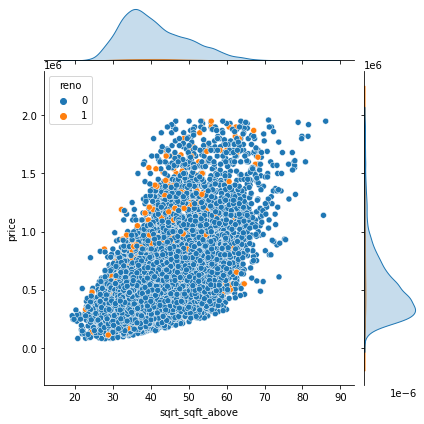

In [16]:
sns.jointplot(x='sqrt_sqft_above', y="price", hue='reno',data=df);
#hue="Closest_WF",col = 'reno', 

In [17]:
coef_hist = pd.DataFrame(coefficients)


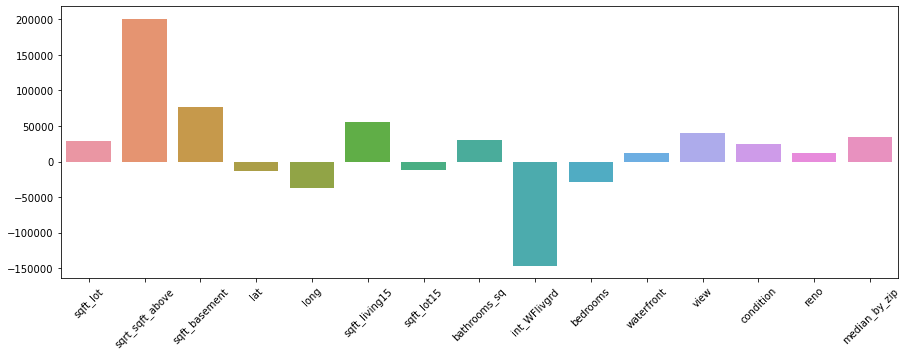

In [18]:

fig, ax = plt.subplots(figsize=(15,5))

len(coef_hist[1].values),len(coef_hist[0].values)

#y = abs(coef_hist[1].values)

y = coef_hist[1].values
labels = coef_hist[0].values
ax = sns.barplot(y=y,x=labels)
plt.xticks(rotation=45);

In [19]:
#kbest
# from sklearn.feature_selection import SelectKBest, chi2

In [20]:
# df_ohe = pd.get_dummies(df[categoricals])

# preprocessed = pd.concat([df_cont, df_ohe],axis=1)



# X = preprocessed.drop('price',axis=1)


# imp_mean = SimpleImputer(strategy='mean')
# imp_mean.fit_transform(X)



# scale = StandardScaler()

# X = scale.fit_transform(X)

# X = pd.DataFrame(X)

# y = preprocessed['price']


# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [21]:
# linreg = LinearRegression()

In [22]:
#use the best
#non-negative input?
#X_best = SelectKBest(chi2, k=10).fit_transform(X_train,y_train)
